#Overview

- Understand how aggregating data from different sources, as poll aggregators do for poll data, can improve the precision of a prediction.
- Understand how to fit a multilevel model to the data to forecast, for example, election results.
- Explain why a simple aggregation of data is insufficient to combine results because of factors such as pollster bias.
- Use a data-driven model to account for additional types of sampling variability such as pollster-to-pollster variability.

##1.Poll Aggregators

- Poll aggregators combine the results of many polls to simulate polls with a large sample size and therefore generate more precise estimates than individual polls.
- Polls can be simulated with a Monte Carlo simulation and used to construct an estimate of the spread and confidence intervals.
- The actual data science exercise of forecasting elections involves more complex statistical modeling, but these underlying ideas still apply.


Code: Simulating polls
Note that to compute the exact 95% confidence interval, we would use qnorm(.975)xSE_hat instead of 2xSE_hat.

In [59]:
d <- 0.039
Ns <- c(1298, 533, 1342, 897, 774, 254, 812, 324, 1291, 1056, 2172, 516)
p <- (d+1)/2

# calculate confidence intervals of the spread
confidence_intervals <- sapply(Ns, function(N){
    X <- sample(c(0,1), size=N, replace=TRUE, prob = c(1-p, p))
    X_hat <- mean(X)
    SE_hat <- sqrt(X_hat*(1-X_hat)/N)
    2*c(X_hat, X_hat - 2*SE_hat, X_hat + 2*SE_hat) - 1 #d_hat
})

# generate a data frame storing results
polls <- data.frame(poll = 1:ncol(confidence_intervals),
                    t(confidence_intervals), sample_size = Ns)
names(polls) <- c("poll", "estimate", "low", "high", "sample_size")
polls

poll,estimate,low,high,sample_size
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.020030817,-0.0354707836,0.07553242,1298
2,0.009380863,-0.0772449415,0.09600667,533
3,0.005961252,-0.0486328871,0.06055539,1342
4,0.030100334,-0.0366474636,0.09684813,897
5,0.085271318,0.0136446370,0.15689800,774
6,0.070866142,-0.0543095137,0.19604180,254
7,0.029556650,-0.0405989265,0.09971223,812
8,0.086419753,-0.0242756708,0.19711518,324
9,0.027110767,-0.0285318074,0.08275334,1291


Code: Calculating the spread of combined polls

Note that to compute the exact 95% confidence interval, we would use qnorm(.975) instead of 1.96.

In [63]:
d_hat <- polls %>%
    summarize(avg = sum(estimate*sample_size) / sum(sample_size)) %>%
    .$avg
d_hat
p_hat <- (1+d_hat)/2
p_hat
moe <- 2*1.96*sqrt(p_hat*(1-p_hat)/sum(polls$sample_size))   
round(d_hat*100,2)
round(moe*100, 3)

[1] 0.03647174

[1] 0.5182359

[1] 3.65

[1] 1.845

##2.Pollsters and Multilevel Models

- Different poll aggregators generate different models of election results from the same poll data. This is because they use different statistical models.
- We will use actual polling data about the popular vote from the 2016 US presidential election to learn the principles of statistical modeling.

##3. Poll Data and Pollster Bias

- We analyze real 2016 US polling data organized by FiveThirtyEight. We start by using reliable national polls taken within the week before the election to generate an urn model.
- Consider $ p $ the proportion voting for Clinton and $ 1−p $ the proportion voting for Trump. We are interested in the spread $ d=2p−1 $.
- Poll results are a random normal variable with expected value of the spread  $d$  and standard error $2\sqrt{p(1-p)/N}$ .
- Our initial estimate of the spread did not include the actual spread. Part of the reason is that different pollsters have different numbers of polls in our dataset, and each pollster has a bias.
- $Pollster bias $reflects the fact that repeated polls by a given pollster have an expected value different from the actual spread and different from other pollsters. Each pollster has a different bias.
- The urn model does not account for pollster bias. We will develop a more flexible data-driven model that can account for effects like bias.

Code: Generating simulated poll data

[1] "state"            "startdate"        "enddate"          "pollster"        
 [5] "grade"            "samplesize"       "population"       "rawpoll_clinton" 
 [9] "rawpoll_trump"    "rawpoll_johnson"  "rawpoll_mcmullin" "adjpoll_clinton" 
[13] "adjpoll_trump"    "adjpoll_johnson"  "adjpoll_mcmullin"

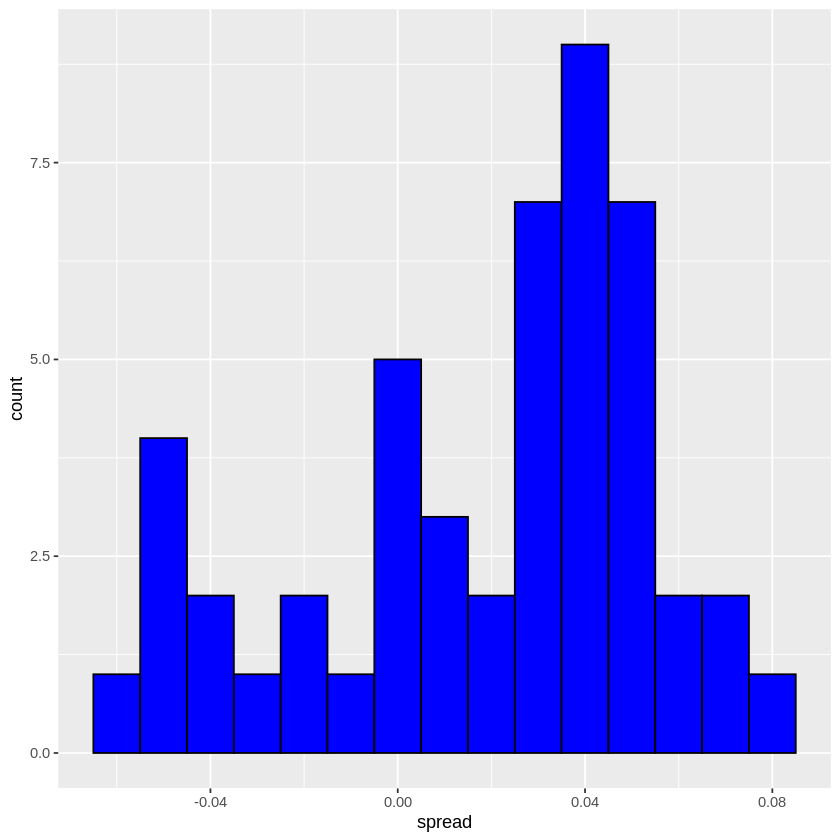

In [65]:
library(dslabs)
data(polls_us_election_2016)
names(polls_us_election_2016)

# keep only national polls from week before election with a grade considered reliable
polls <- polls_us_election_2016 %>%
    filter(state == "U.S." & enddate >= "2016-10-31" &
               (grade %in% c("A+", "A", "A-", "B+") | is.na(grade)))

# add spread estimate
polls <- polls %>%
    mutate(spread = rawpoll_clinton/100 - rawpoll_trump/100)

# compute estimated spread for combined polls
d_hat <- polls %>%
    summarize(d_hat = sum(spread * samplesize) / sum(samplesize)) %>%
    .$d_hat

# compute margin of error
p_hat <- (d_hat+1)/2
moe <- 1.96 * 2 * sqrt(p_hat*(1-p_hat)/sum(polls$samplesize))

# histogram of the spread
polls %>%
    ggplot(aes(spread)) +
    geom_histogram(color="black", binwidth = .01,fill="blue")

Code: Investigating poll data and pollster bias

`summarise()` ungrouping output (override with `.groups` argument)



pollster,n()
<fct>,<int>
ABC News/Washington Post,7
Angus Reid Global,1
CBS News/New York Times,2
Fox News/Anderson Robbins Research/Shaw & Company Research,2
IBD/TIPP,8
Insights West,1
Ipsos,6
Marist College,1
Monmouth University,1


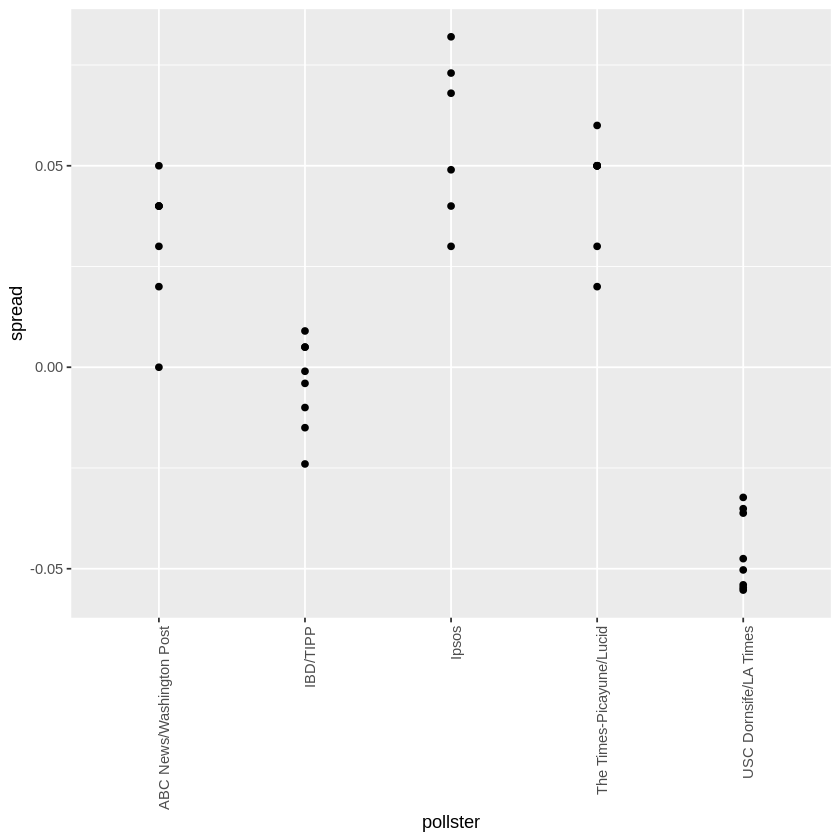

In [67]:
# number of polls per pollster in week before election
polls %>% group_by(pollster) %>% summarize(n())

# plot results by pollsters with at least 6 polls
polls %>% group_by(pollster) %>%
    filter(n() >= 6) %>%
    ggplot(aes(pollster, spread)) +
    geom_point() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1))



In [68]:
# standard errors within each pollster
polls %>% group_by(pollster) %>%
    filter(n() >= 6) %>%
    summarize(se = 2 * sqrt(p_hat * (1-p_hat) / median(samplesize)))

`summarise()` ungrouping output (override with `.groups` argument)



pollster,se
<fct>,<dbl>
ABC News/Washington Post,0.02654389
IBD/TIPP,0.03332069
Ipsos,0.02251943
The Times-Picayune/Lucid,0.01963986
USC Dornsife/LA Times,0.01831826


##4. Data-Driven Models

- Instead of using an urn model where each poll is a random draw from the same distribution of voters, we instead define a model using an urn that contains poll results from all possible pollsters.
- We assume the expected value of this model is the actual spread  d=2p−1 .
Our new standard error  σ  now factors in pollster-to-pollster variability. It can no longer be calculated from  p  or  d  and is an unknown parameter.
- The central limit theorem still works to estimate the sample average of many polls  X1,...,XN  because the average of the sum of many random variables is a normally distributed random variable with expected value  d  and standard error  $σ/\sqrt{N}$ .
We can estimate the unobserved  $σ$  as the sample standard deviation, which is calculated with the sd function.

Note that to compute the exact 95% confidence interval, we would use qnorm(.975) instead of 1.96.

avg,se,start,end
<dbl>,<dbl>,<dbl>,<dbl>
2.9,0.6,1.7,4.1


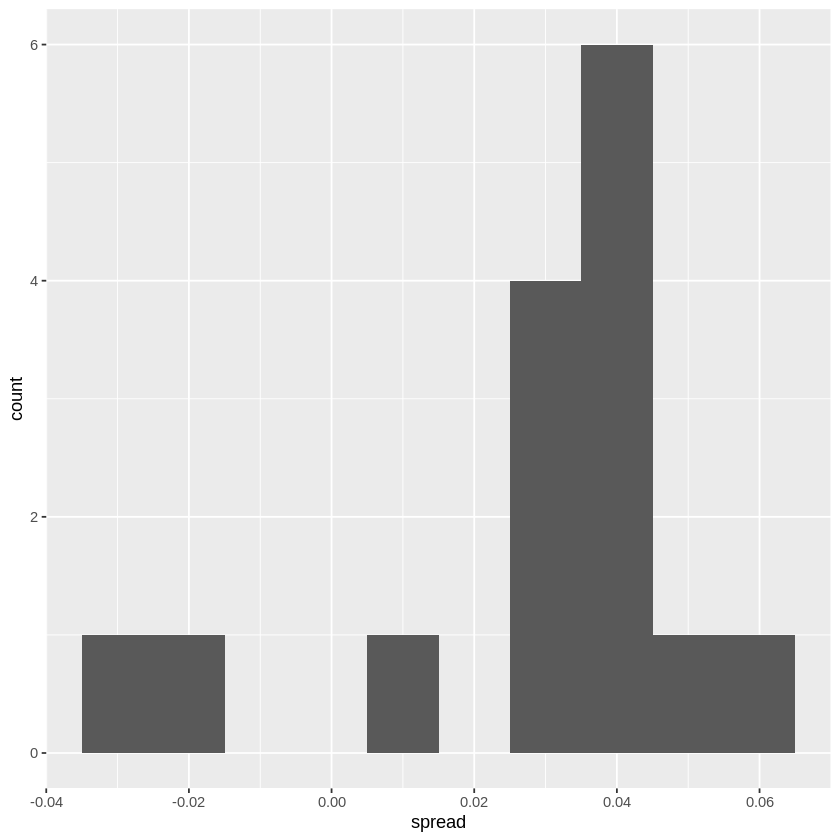

In [70]:
# collect last result before the election for each pollster
one_poll_per_pollster <- polls %>% group_by(pollster) %>%
    filter(enddate == max(enddate)) %>%      # keep latest poll
    ungroup()

# histogram of spread estimates
one_poll_per_pollster %>%
    ggplot(aes(spread)) + geom_histogram(binwidth = 0.01)

# construct 95% confidence interval
results <- one_poll_per_pollster %>%
    summarize(avg = mean(spread), se = sd(spread)/sqrt(length(spread))) %>%
    mutate(start = avg - 1.96*se, end = avg + 1.96*se)
round(results*100, 1)

# Assessment 4.1: Statistical Models

Exercise 1 - Heights Revisited

We have been using urn models to motivate the use of probability models. However, most data science applications are not related to data obtained from urns. More common are data that come from individuals. Probability plays a role because the data come from a random sample. The random sample is taken from a population and the urn serves as an analogy for the population.

Let's revisit the heights dataset. For now, consider x to be the heights of all males in the data set. Mathematically speaking, x is our population. Using the urn analogy, we have an urn with the values of x in it.

What are the population average and standard deviation of our population?

In [71]:
# Load the 'dslabs' package and data contained in 'heights'
library(dslabs)
data(heights)

# Make a vector of heights from all males in the population
x <- heights %>% filter(sex == "Male") %>%
  .$height

# Calculate the population average. Print this value to the console.
mean(x)

# Calculate the population standard deviation. Print this value to the console.
sd(x)

[1] 69.31475

[1] 3.611024

Exercise 2 - Sample the population of heights

Call the population average computed above $\mu$  and the standard deviation $\sigma$. Now take a sample of size 50, with replacement, and construct an estimate for $\mu$  and $\sigma$.


In [72]:
# The vector of all male heights in our population `x` has already been loaded for you. You can examine the first six elements using `head`.
head(x)

# Use the `set.seed` function to make sure your answer matches the expected result after random sampling
set.seed(1)

# Define `N` as the number of people measured
N <- 50

# Define `X` as a random sample from our population `x`
X<- sample(x,size=N,replace=TRUE)
X
# Calculate the sample average. Print this value to the console.
mean(X)

# Calculate the sample standard deviation. Print this value to the console.
sd(X)

[1] 75 70 68 74 61 67

[1] 71.00000 69.00000 70.00000 66.92913 68.50000 79.05000 72.00000 72.00000
 [9] 69.00000 66.00000 69.00000 70.86614 72.00000 66.00000 70.00000 73.00000
[17] 69.00000 76.00000 72.44000 72.44000 74.00000 74.00000 74.00000 63.00000
[25] 69.00000 70.86614 68.50394 72.00000 70.00000 68.00000 70.00000 72.00000
[33] 68.00000 67.00000 76.00000 70.00000 73.00000 68.00000 69.00000 77.16540
[41] 72.00000 66.00000 67.50000 68.00000 72.00000 63.38583 73.00000 78.00000
[49] 68.00000 68.00000

[1] 70.47293

[1] 3.426742

Exercise 3 - Sample and Population Averages

What does the central limit theory tell us about the sample average and how it is related to $\mu$, the population average?

It is a random variable with expected value $\mu$ and standard error $\sigma/\sqrt{N}$.

Exercise 4 - Confidence Interval Calculation

We will use $\overline{X}$
 as our estimate of the heights in the population from our sample size $N$. We know from previous exercises that the standard estimate of our error $\overline{X} -\mu$
 is $\sigma/\sqrt{N}$.

Construct a 95% confidence interval for $\mu$.

In [75]:
# Use the `set.seed` function to make sure your answer matches the expected result after random sampling
set.seed(1)

# Define `N` as the number of people measured
N <- 50

# Define `X` as a random sample from our population `x`
X <- sample(x, N, replace = TRUE)
# Define `se` as the standard error of the estimate. Print this value to the console.
X_hat <- mean(X)
se_hat <- sd(X)
se <- se_hat/sqrt(N)
se


# Construct a 95% confidence interval for the population average based on our sample. Save the lower and then the upper confidence interval to a variable called `ci`.
ci <- c(qnorm(0.025, mean(X), se), qnorm(0.975, mean(X), se))


[1] 71.00000 69.00000 70.00000 66.92913 68.50000 79.05000 72.00000 72.00000
 [9] 69.00000 66.00000 69.00000 70.86614 72.00000 66.00000 70.00000 73.00000
[17] 69.00000 76.00000 72.44000 72.44000 74.00000 74.00000 74.00000 63.00000
[25] 69.00000 70.86614 68.50394 72.00000 70.00000 68.00000 70.00000 72.00000
[33] 68.00000 67.00000 76.00000 70.00000 73.00000 68.00000 69.00000 77.16540
[41] 72.00000 66.00000 67.50000 68.00000 72.00000 63.38583 73.00000 78.00000
[49] 68.00000 68.00000

[1] 0.4846145

Exercise 5 - Monte Carlo Simulation for Heights

Now run a Monte Carlo simulation in which you compute 10,000 confidence intervals as you have just done. What proportion of these intervals include $\mu$?

In [76]:
# Define `mu` as the population average
mu <- mean(x)

# Use the `set.seed` function to make sure your answer matches the expected result after random sampling
set.seed(1)

# Define `N` as the number of people measured
N <- 50

# Define `B` as the number of times to run the model
B <- 10000

# Define an object `res` that contains a logical vector for simulated intervals that contain mu
res <- replicate(B,{
  X<- sample(x,N,replace=TRUE)
  X_hat <- mean(X)
  se_hat <- sd(X)
  se <- se_hat/sqrt(N)
  interval <- c(qnorm(0.025, mean(X), se) , qnorm(0.975, mean(X), se))
  between(mu, interval[1], interval[2])
})
mean(res)
# Calculate the proportion of results in `res` that include mu. Print this value to the console.

[1] 0.9479

Exercise 6 - Visualizing Polling Bias


In this section, we used visualization to motivate the presence of pollster bias in election polls. Here we will examine that bias more rigorously. Lets consider two pollsters that conducted daily polls and look at national polls for the month before the election.

Is there a poll bias? Make a plot of the spreads for each poll.

[1] "state"            "startdate"        "enddate"          "pollster"        
 [5] "grade"            "samplesize"       "population"       "rawpoll_clinton" 
 [9] "rawpoll_trump"    "rawpoll_johnson"  "rawpoll_mcmullin" "adjpoll_clinton" 
[13] "adjpoll_trump"    "adjpoll_johnson"  "adjpoll_mcmullin" "spread"

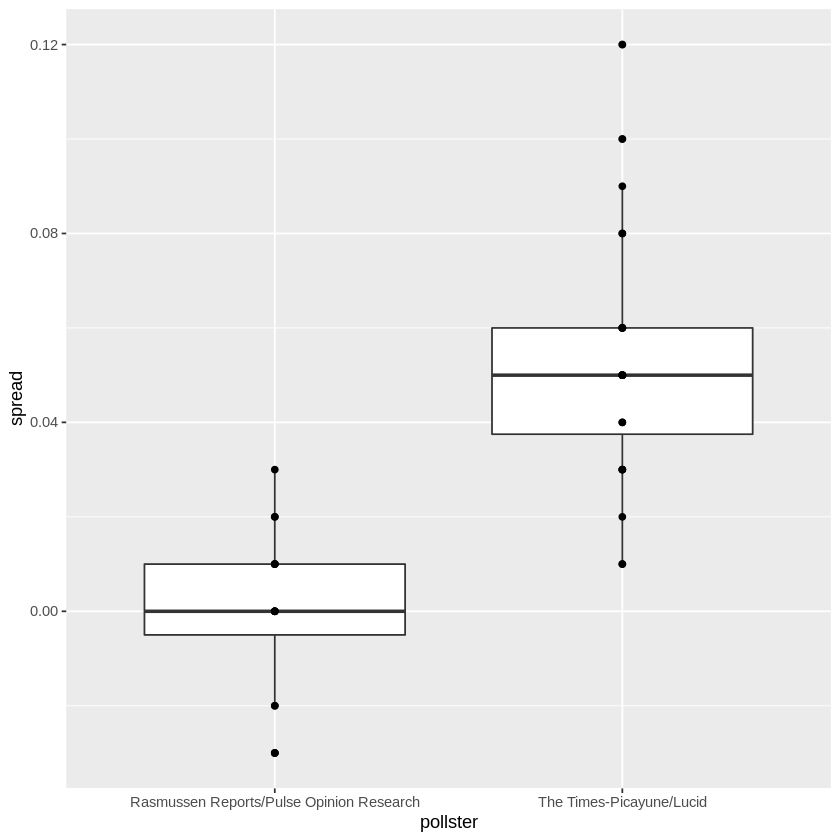

In [78]:
# Load the libraries and data you need for the following exercises
library(dslabs)
library(dplyr)
library(ggplot2)
data("polls_us_election_2016")

# These lines of code filter for the polls we want and calculate the spreads
polls <- polls_us_election_2016 %>% 
  filter(pollster %in% c("Rasmussen Reports/Pulse Opinion Research","The Times-Picayune/Lucid") &
           enddate >= "2016-10-15" &
           state == "U.S.") %>% 
  mutate(spread = rawpoll_clinton/100 - rawpoll_trump/100) 
names(polls)
# Make a boxplot with points of the spread for each pollster
polls %>% ggplot(aes(pollster,spread))+geom_boxplot()+geom_point()

Exercise 7 - Defining Pollster Bias

The data do seem to suggest there is a difference between the pollsters. However, these data are subject to variability. Perhaps the differences we observe are due to chance. Under the urn model, both pollsters should have the same expected value: the election day difference,d .

We will model the observed data $Y_{ij}$ in the following way:
$Y_{ij}=d+b_{i}+ε_{ij}$

with $i=1,2$ indexing the two pollsters, $b_{i}$ the bias for pollster i , and $ε_{ij}$ poll to poll chance variability. We assume the ε are independent from each other, have expected value 0 and standard deviation $\sigma_{i}$ regardless of j.

Which of the following statements best reflects what we need to know to determine if our data fit the urn model?

Is $b_{1} ≠ b_{2}$?

Exercise 8 - Derive Expected Value

We modelled the observed data $Y_{ij}$ as:
$Y_{ij}=d+b_{i}+ε_{ij}$

On the right side of this model, only $ε_{ij}$ is a random variable. The other two values are constants.

What is the expected value of $Y_{1j}$?

$d+b_{1}$

Exercise 9 - Expected Value and Standard Error of Poll 1

Suppose we define $\overline{Y_{1}}$
 as the average of poll results from the first poll and $\sigma_{1}$ as the standard deviation of the first poll.

What is the expected value and standard error of  $\overline{Y_{1}}$
?


The expected value is $d+b_{1}$ and the standard error is $\sigma_1/\sqrt{N_{1}}$

Exercise 10 - Expected Value and Standard Error of Poll 2

Suppose we define $\overline{Y_{2}}$
 as the average of poll results from the first poll and $\sigma_{2}$ as the standard deviation of the first poll.

What is the expected value and standard error of  $\overline{Y_{2}}$
?


The expected value is $d+b_{2}$ and the standard error is $\sigma_2/\sqrt{N_{2}}$

Exercise 11 - Difference in Expected Values Between Polls

Using what we learned by answering the previous questions, what is the expected value of  $\overline{Y_{2}}-\overline{Y_{1}}$ 
?

$b_{2}-b_{1}$

Exercise 12 - Standard Error of the Difference Between Polls

Using what we learned by answering the questions above, what is the standard error of $\overline{Y_{2}}-\overline{Y_{1}}$
?

$\sqrt{\frac{\sigma_{2}^{2}}{N_{2}}+\frac{\sigma_{1}^{2}}{N_{1}}}$

Exercise 13 - Compute the Estimates

The answer to the previous question depends on $\sigma_{1}$
 and $\sigma_{2}$
, which we don't know. We learned that we can estimate these values using the sample standard deviation.

Compute the estimates of $\sigma_{1}$
 and $\sigma_{2}$
.

In [80]:
# Create an object called `sigma` that contains a column for `pollster` and a column for `s`, the standard deviation of the spread
polls %>% group_by(pollster)
sigma <- polls %>% group_by(pollster) %>% summarize(s = sd(spread))

# Print the contents of sigma to the console
sigma

state,startdate,enddate,pollster,grade,samplesize,population,rawpoll_clinton,rawpoll_trump,rawpoll_johnson,rawpoll_mcmullin,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,spread
<fct>,<date>,<date>,<fct>,<fct>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
U.S.,2016-11-05,2016-11-07,The Times-Picayune/Lucid,NA,2521,lv,45,40,5,NA,45.13966,42.26495,3.679914,NA,0.05
U.S.,2016-11-02,2016-11-06,Rasmussen Reports/Pulse Opinion Research,C+,1500,lv,45,43,4,NA,45.56041,43.13745,4.418502,NA,0.02
U.S.,2016-11-01,2016-11-03,Rasmussen Reports/Pulse Opinion Research,C+,1500,lv,44,44,4,NA,44.66353,44.28981,4.331246,NA,0.00
U.S.,2016-11-04,2016-11-06,The Times-Picayune/Lucid,NA,2584,lv,45,40,5,NA,45.22830,42.30433,3.770880,NA,0.05
U.S.,2016-10-31,2016-11-02,Rasmussen Reports/Pulse Opinion Research,C+,1500,lv,42,45,4,NA,42.67626,45.41689,4.239500,NA,-0.03
U.S.,2016-11-03,2016-11-05,The Times-Picayune/Lucid,NA,2526,lv,45,40,5,NA,45.31041,42.34422,3.779955,NA,0.05
U.S.,2016-10-27,2016-10-31,Rasmussen Reports/Pulse Opinion Research,C+,1500,lv,44,44,5,NA,44.67792,44.98535,4.871296,NA,0.00
U.S.,2016-10-30,2016-11-01,Rasmussen Reports/Pulse Opinion Research,C+,1500,lv,44,44,5,NA,44.68157,44.56407,5.138172,NA,0.00
U.S.,2016-11-02,2016-11-04,The Times-Picayune/Lucid,NA,2561,lv,45,39,5,NA,45.37288,41.39494,3.764886,NA,0.06


`summarise()` ungrouping output (override with `.groups` argument)



pollster,s
<fct>,<dbl>
Rasmussen Reports/Pulse Opinion Research,0.01768945
The Times-Picayune/Lucid,0.02678078


Exercise 14 - Probability Distribution of the Spread

What does the central limit theorem tell us about the distribution of the differences between the pollster averages, $\overline{Y_{2}}- \overline{Y_{1}}$ 
?

If we assume $N_{2}$
 and $N_{1}$
 are large enough,  $\overline{Y_{2}}$
 and  $\overline{Y_{1}}$
, and their difference, are approximately normal.

Exercise 15 - Calculate the 95% Confidence Interval of the Spreads

We have constructed a random variable that has expected value $b_{2}-b_{1}$
, the pollster bias difference. If our model holds, then this random variable has an approximately normal distribution. The standard error of this random variable depends on $\sigma_{1}$
 and $\sigma_{2
 }$
, but we can use the sample standard deviations we computed earlier. We have everything we need to answer our initial question: is  $b_{2}-b_{1}$
 different from 0?

Construct a 95% confidence interval for the difference 
  $b_{2}$and $b_{1}$
. Does this interval contain zero?


In [83]:
# The `polls` data have already been loaded for you. Use the `head` function to examine them.
#head(polls)

# Create an object called `res` that summarizes the average, standard deviation, and number of polls for the two pollsters.
res <- polls %>% group_by(pollster) %>% summarize(avg=mean(spread), s = sd(spread), N=n())
res


# Store the difference between the larger average and the smaller in a variable called `estimate`. Print this value to the console.
estimate <- max(res$avg)-min(res$avg)
estimate



# Store the standard error of the estimates as a variable called `se_hat`. Print this value to the console.
se_hat <- sqrt(res$s[2]^2/res$N[2] + res$s[1]^2/res$N[1])
se_hat


# Calculate the 95% confidence interval of the spreads. Save the lower and then the upper confidence interval to a variable called `ci`.
ci <- c(estimate - qnorm(0.975)*se_hat, estimate + qnorm(0.975)*se_hat)
ci


`summarise()` ungrouping output (override with `.groups` argument)



pollster,avg,s,N
<fct>,<dbl>,<dbl>,<int>
Rasmussen Reports/Pulse Opinion Research,0.00062500,0.01768945,16
The Times-Picayune/Lucid,0.05291667,0.02678078,24


[1] 0.05229167

[1] 0.007031433

[1] 0.03851031 0.06607302

Exercise 16 - Calculate the P-value


The confidence interval tells us there is relatively strong pollster effect resulting in a difference of about 5%. Random variability does not seem to explain it.

Compute a p-value to relay the fact that chance does not explain the observed pollster effect.

In [85]:
# We made an object `res` to summarize the average, standard deviation, and number of polls for the two pollsters.
res <- polls %>% group_by(pollster) %>% 
  summarize(avg = mean(spread), s = sd(spread), N = n()) 
res
# The variables `estimate` and `se_hat` contain the spread estimates and standard error, respectively.
estimate <- res$avg[2] - res$avg[1]
se_hat <- sqrt(res$s[2]^2/res$N[2] + res$s[1]^2/res$N[1])

# Calculate the p-value
2 * (1 - pnorm(estimate / se_hat, 0, 1))

`summarise()` ungrouping output (override with `.groups` argument)



pollster,avg,s,N
<fct>,<dbl>,<dbl>,<int>
Rasmussen Reports/Pulse Opinion Research,0.00062500,0.01768945,16
The Times-Picayune/Lucid,0.05291667,0.02678078,24


[1] 1.030287e-13

Exercise 17 - Comparing Within-Poll and Between-Poll Variability

We compute statistic called the t-statistic by dividing our estimate of $b_{2}-b_{1}$
 by its estimated standard error:
$\frac{\overline{Y_{2}}-\overline{Y_{1}}}{\sqrt{s_{2}^{2}/N_{2}+s_{1}^{2}/N_{1}}}$
 
Later we learn will learn of another approximation for the distribution of this statistic for values of $N_{1}$
 and $N_{2}$
 that aren't large enough for the CLT.

Note that our data has more than two pollsters. We can also test for pollster effect using all pollsters, not just two. The idea is to compare the variability across polls to variability within polls. We can construct statistics to test for effects and approximate their distribution. The area of statistics that does this is called Analysis of Variance or ANOVA. We do not cover it here, but ANOVA provides a very useful set of tools to answer questions such as: is there a pollster effect?

Compute the average and standard deviation for each pollster and examine the variability across the averages and how it compares to the variability within the pollsters, summarized by the standard deviation.

In [86]:
# Execute the following lines of code to filter the polling data and calculate the spread
polls <- polls_us_election_2016 %>% 
  filter(enddate >= "2016-10-15" &
           state == "U.S.") %>%
  group_by(pollster) %>%
  filter(n() >= 5) %>% 
  mutate(spread = rawpoll_clinton/100 - rawpoll_trump/100) %>%
  ungroup()

# Create an object called `var` that contains columns for the pollster, mean spread, and standard deviation. Print the contents of this object to the console.
var <- polls %>% group_by(pollster) %>% summarize(avg = mean(spread), s = sd(spread))
var




`summarise()` ungrouping output (override with `.groups` argument)



pollster,avg,s
<fct>,<dbl>,<dbl>
ABC News/Washington Post,0.037333333,0.033904628
CVOTER International,0.027895455,0.017975499
Google Consumer Surveys,0.030280000,0.018476390
Gravis Marketing,0.016000000,0.015165751
IBD/TIPP,0.001047619,0.016832933
Ipsos,0.055272727,0.019464698
Morning Consult,0.041428571,0.014638501
Rasmussen Reports/Pulse Opinion Research,0.000625000,0.017689451
The Times-Picayune/Lucid,0.052916667,0.026780779
